In [1]:
import pandas as pd
from datetime import timedelta

# load dataset 

In [27]:
encounter_df = pd.read_csv("encounters.csv")
condition_df = pd.read_csv("conditions.csv")
observation_df = pd.read_csv("observations.csv")
medication_df = pd.read_csv("medications.csv")

# Ensure all ENCOUNTER-related keys are string

In [28]:
encounter_df['Id'] = encounter_df['Id'].astype(str)
condition_df['ENCOUNTER'] = condition_df['ENCOUNTER'].astype(str)
observation_df['ENCOUNTER'] = observation_df['ENCOUNTER'].astype(str)
medication_df['ENCOUNTER'] = medication_df['ENCOUNTER'].astype(str)



# Normalize date columns

In [29]:

for df in [encounter_df, condition_df, observation_df, medication_df]:
    for col in df.columns:
        if 'START' in col or 'STOP' in col or 'DATE' in col:
            df[col] = pd.to_datetime(df[col], errors='coerce')

# Filter ER encounters only and label function

In [30]:
er_encounters = encounter_df[encounter_df['ENCOUNTERCLASS'].str.lower().str.contains("emergency", na=False)]

def label_future_er(encounter, patient_id):
    start_time = encounter['START']
    cutoff = start_time + timedelta(days=180)
    patient_er = er_encounters[
        (er_encounters['PATIENT'] == patient_id) &
        (er_encounters['START'] > start_time) &
        (er_encounters['START'] <= cutoff)
    ]
    return 1 if not patient_er.empty else 0

encounter_df['future_ER_within_6mo'] = encounter_df.apply(
    lambda row: label_future_er(row, row['PATIENT']), axis=1
)

# Merging

In [31]:
merged_df = encounter_df.merge(
    condition_df,
    how='left',
    left_on='Id',
    right_on='ENCOUNTER',
    suffixes=('', '_condition')
)

In [32]:
merged_df = merged_df.merge(
    observation_df,
    how='left',
    left_on='Id',
    right_on='ENCOUNTER',
    suffixes=('', '_observation')
)

In [34]:
med_agg = medication_df.groupby('ENCOUNTER').agg({
    'TOTALCOST': 'sum',
    'BASE_COST': 'mean',
    'PAYER_COVERAGE': 'mean',
    'DISPENSES': 'sum',
    'CODE': 'nunique'
}).reset_index()

med_agg.columns = [
    'ENCOUNTER',
    'total_meds_cost',
    'avg_med_base_cost',
    'avg_med_coverage',
    'total_dispenses',
    'unique_drugs'
]


merged_df = merged_df.merge(
    med_agg,
    how='left',
    left_on='Id',
    right_on='ENCOUNTER',
    suffixes=('', '_medication')
)

In [35]:
merged_df = merged_df.drop(columns=[
    'ENCOUNTER', 'ENCOUNTER_condition', 'ENCOUNTER_observation', 'ENCOUNTER_medication'
], errors='ignore')

# Merge data

In [36]:
merged_df.to_csv("merge_labeled_er_dataset.csv", index=False)

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# load merge dataset

we have high amount of merge dataset and its very difficult to load that so in that case  i took only 500000 row sample

In [46]:
df = pd.read_csv("merge_labeled_er_dataset.csv", nrows=500000)

# Drop columns not useful for modeling

In [47]:
drop_cols = ['Id', 'PATIENT', 'START', 'STOP', 'DESCRIPTION', 'REASONDESCRIPTION']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Drop high-cardinality object cols or fill NAs

In [48]:
df = df.select_dtypes(exclude='object').fillna(0)

# Define target

In [49]:
X = df.drop(columns=['future_ER_within_6mo'])
y = df['future_ER_within_6mo']

In [50]:
print("Before SMOTE:", y.value_counts())

Before SMOTE: future_ER_within_6mo
0    425033
1     74967
Name: count, dtype: int64


# Balance the dataset using SMOTE

In [51]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

In [52]:
print("After SMOTE:", pd.Series(y_bal).value_counts())

After SMOTE: future_ER_within_6mo
0    425033
1    425033
Name: count, dtype: int64


# Train-test split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, stratify=y_bal, test_size=0.2, random_state=42)

# Model

In [54]:
model = XGBClassifier(n_estimators=100, max_depth=5, scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

C:\Users\Hp\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [15:48:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

# Evaluate

In [55]:
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[67532 17475]
 [ 1707 83300]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.79      0.88     85007
           1       0.83      0.98      0.90     85007

    accuracy                           0.89    170014
   macro avg       0.90      0.89      0.89    170014
weighted avg       0.90      0.89      0.89    170014



# Feature importance

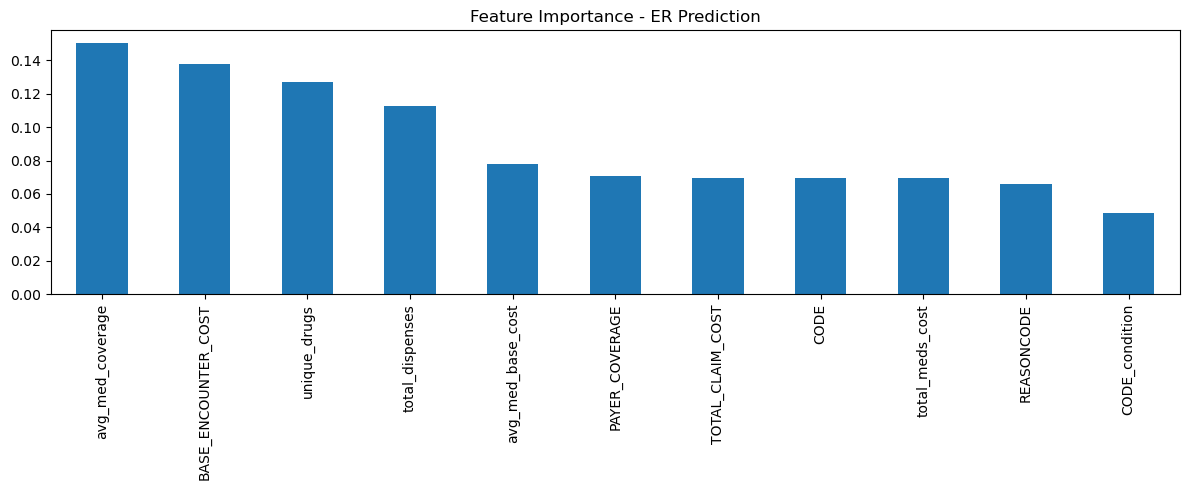

In [56]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5))
plt.title("Feature Importance - ER Prediction")
plt.tight_layout()
plt.show()

In [57]:
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate scores and accuracy

In [58]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probability of class 1


auc = roc_auc_score(y_test, y_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"ROC AUC Score: {auc:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ROC AUC Score: 0.9764
Precision:     0.8266
Recall:        0.9799
F1 Score:      0.8967

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.79      0.88     85007
           1       0.83      0.98      0.90     85007

    accuracy                           0.89    170014
   macro avg       0.90      0.89      0.89    170014
weighted avg       0.90      0.89      0.89    170014



# Confusion Matrix

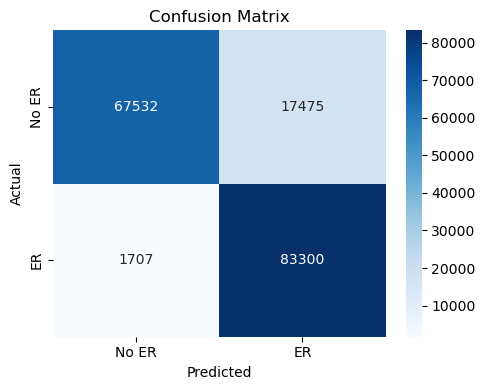

In [59]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No ER", "ER"], yticklabels=["No ER", "ER"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve

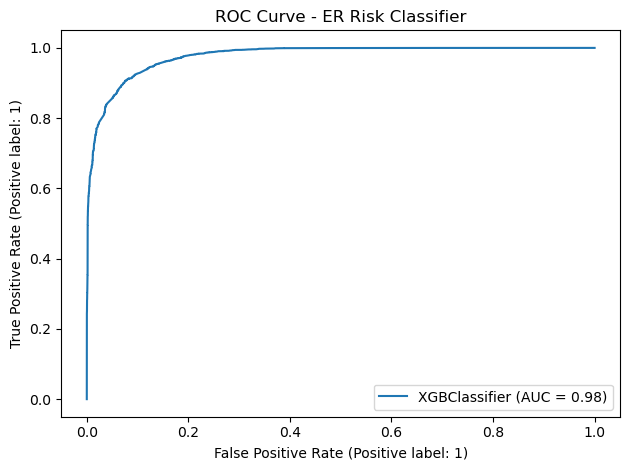

In [60]:
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve - ER Risk Classifier")
plt.tight_layout()
plt.show()